In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
import tensorflow.keras.layers as ly
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
train_b = True

In [3]:
def RMSE(y_test,y_pred):
    y_test = list(y_test); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])**2 for i in range(n)]
    return np.sqrt(sum(rmse_list)/float(n))
def RRMSE(y_test,y_pred):
    y_test = list(y_test); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])**2 for i in range(n)]
    n = [float(y_test[i])**2 for i in range(n)]
    return np.sqrt(sum(rmse_list)/sum(n))    
def RMSE_list(y_test,y_pred):
    y_test = list(y_test); 
    y_test = [list(ln) for ln in y_test]
    y_pred = list(y_pred); 
    y_pred = [list(ln) for ln in y_pred]
    n = len(y_test); m = len(y_test[0])
    rmse_list = [np.square(float(y_test[i][j]-y_pred[i][j])) for i in range(n) for j in range(m)]
    return np.sqrt(sum(rmse_list)/float(n))

#Load and Reshape Data

In [4]:
DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Merged"
hist_window=18;forecast_window=18
#hist_window=int(12*60/5)

In [6]:
data =  pd.read_csv(f"{DATA_DIR}/full_merge_v2.csv")

future_var = ['Dni','HourlyDryBulbTemperature','HourlyRelativeHumidity']
for c in future_var:
  data[c+" Future"] = data[c].shift(-forecast_window).backfill()

used_var = ['N.Y.C.','Dni','HourlyDryBulbTemperature','HourlyRelativeHumidity','Dni Future','HourlyDryBulbTemperature Future','HourlyRelativeHumidity Future']
data = data[used_var].backfill();
data = data.dropna(how='any')

for c in used_var:
  #print(data[c].head(15));
  print(c,len(data[c].index),data[c].mean(),data[c].std())

print(data.head(5).to_string())
n = len(data.index)
t = int(365*24*(60/5))
num_var = len(used_var)

N.Y.C. 631062 5785.801098166661 1225.8381262919374
Dni 631062 176.74872041098973 310.4973536354869
HourlyDryBulbTemperature 631062 55.41743325211331 16.947708813988072
HourlyRelativeHumidity 631062 69.95292890500245 20.45526331079287
Dni Future 631062 176.74872041098973 310.4973536354869
HourlyDryBulbTemperature Future 631062 55.41756829900275 16.947637395595507
HourlyRelativeHumidity Future 631062 69.95433120965156 20.45563787357539
   N.Y.C.  Dni  HourlyDryBulbTemperature  HourlyRelativeHumidity  Dni Future  HourlyDryBulbTemperature Future  HourlyRelativeHumidity Future
0  5116.9  0.0                      44.0                    51.0         0.0                        44.588235                      49.823529
1  5102.1  0.0                      44.0                    51.0         0.0                        44.686275                      49.627451
2  5074.9  0.0                      44.0                    51.0         0.0                        44.784314                      49.43137

In [ ]:
data

In [7]:
m = 5574.113154123897;std = 1157.6820234795014
m_s = 176.74872041098973 ;std_s = 310.4973536354869
m_t = 56.030910041113;std_t = 16.507268780702415
m_h = 67.15854537779073;std_h = 19.60851278565285

m_list = [m,m_s,m_t,m_h,m_s,m_t,m_h]
std_list = [std,std_s,std_t,std_h,std_s,std_t,std_h]

def untransform_dataset_old(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==3:
    ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    dataset=dataset.reshape(nv,ns*tw)
    dataset = np.array([(dataset[i]*stdi[i])+mi[i] for i in range(s[1])])
    dataset=dataset.reshape(s[0],s[1],s[2])
  else: 
    dataset=(dataset*stdi[0])+mi[0]
  return dataset

def create_dataset(dataset, hist_window=18,forecast_window=18):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(len(dataset)-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].reshape(-1); dataX.append(a)
    dataY.append(dataset[i + hist_window:  i + hist_window+forecast_window])
  return np.array(dataX), np.array(dataY)
def create_dataset_mult(dataset, hist_window=18,forecast_window=18,num_var=3):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(dataset.shape[0]-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].T
    dataX.append(a)
    
    e = dataset[i + hist_window:  i + hist_window+forecast_window, 0]
    dataY.append(e)
  return np.array(dataX), np.array(dataY)

def transform_dataset(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==2:
    #ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    ns,nv = s
    dataset=dataset.T 
    dataset = np.array([(dataset[i]-mi[i])/stdi[i] for i in range(s[1])])
    dataset=dataset.T 
  else:
    dataset=(dataset-mi[0])/stdi[0] 
  return dataset
def untransform_dataset(dataset,mi=m_list,stdi=std_list):
  dataset=(dataset*stdi[0])+mi[0]
  return dataset  
dataset = data[used_var].values
dataset_xfr = transform_dataset(dataset)

x,y = create_dataset_mult(dataset_xfr,hist_window,forecast_window,num_var)
train,label_t = x[0:n-t],y[0:n-t]
valid,label_v = x[n-t:], y[n-t:]

In [8]:
# reshape input to be [samples, time steps, features]
#print(train.shape)
#train = np.reshape(train, (train.shape[0], num_var, train.shape[1]))
#valid = np.reshape(valid, (valid.shape[0], num_var, valid.shape[1]))

#Build Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               47600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 18)                1818      
                                                                 
Total params: 49,418
Trainable params: 49,418
Non-trainable params: 0
_________________________________________________________________


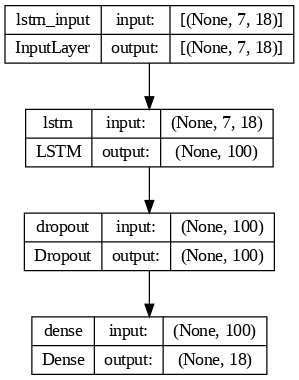

In [9]:
import datetime
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Saved_Model"
def create_LSTM_model(LSTM_i = 4, dropout=0.3,
                      learning_rate=0.00005,var_num = 2,
                      hist_window=18,forecast_window=18):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
    """
    model = Sequential()
    model.add(LSTM(LSTM_i, input_shape=(var_num,hist_window)))
    model.add(Dropout(.1))
    model.add(Dense(forecast_window))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_LSTM_model(LSTM_i=100, var_num=num_var)
model.summary()
plot_model(model, show_shapes=True, dpi=90)

In [10]:
#Fit Model
model_name = 'test_model_slope_with_solar_weather_future_100_humidity.h5'
print(datetime.datetime.now())
if train_b:
  model.fit(train, label_t, epochs=5, batch_size=16, verbose=2)
  model.save(f"{MODEL_DIR}/{model_name}",save_format='h5')
else: 
  model.load_weights(f"{MODEL_DIR}/{model_name}") 

2023-03-04 19:40:57.370934
Epoch 1/5
32872/32872 - 260s - loss: 0.0162 - 260s/epoch - 8ms/step
Epoch 2/5
32872/32872 - 247s - loss: 0.0075 - 247s/epoch - 8ms/step
Epoch 3/5
32872/32872 - 240s - loss: 0.0067 - 240s/epoch - 7ms/step
Epoch 4/5
32872/32872 - 257s - loss: 0.0063 - 257s/epoch - 8ms/step
Epoch 5/5
32872/32872 - 253s - loss: 0.0059 - 253s/epoch - 8ms/step


3284/3284 [==============================] - 16s 5ms/step
Total Test Score: 320.01 RMSE
90 Min Test Score: 106.42 RMSE
Relative Test Score: 1.83 perc RMSE


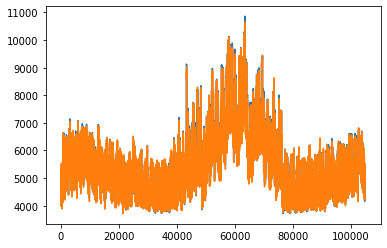

In [11]:
# make predictions
valid,label_v = x[n-t:], y[n-t:]
label_p   = model.predict(valid)

## invert predictions
label_p = untransform_dataset(label_p)
label_v = untransform_dataset(label_v)

# calculate root mean squared error
print('Total Test Score: %.2f RMSE' % (RMSE_list(label_v, label_p)))

for i,ln in enumerate(label_p):
  if i==0: 
    label_p_plot=list(label_p[0])
    label_v_plot=list(label_v[0])
  else:
    label_p_plot=label_p_plot+ [label_p[i][-1]]
    label_v_plot=label_v_plot+ [label_v[i][-1]]

print('90 Min Test Score: %.2f RMSE' % (RMSE(label_v_plot, label_p_plot)))
print('Relative Test Score: %.2f perc RMSE' % (100*RRMSE(label_v_plot, label_p_plot)))

plt.plot(label_v_plot);
plt.plot(label_p_plot)
plt.show()

# Load prediction with weather correction

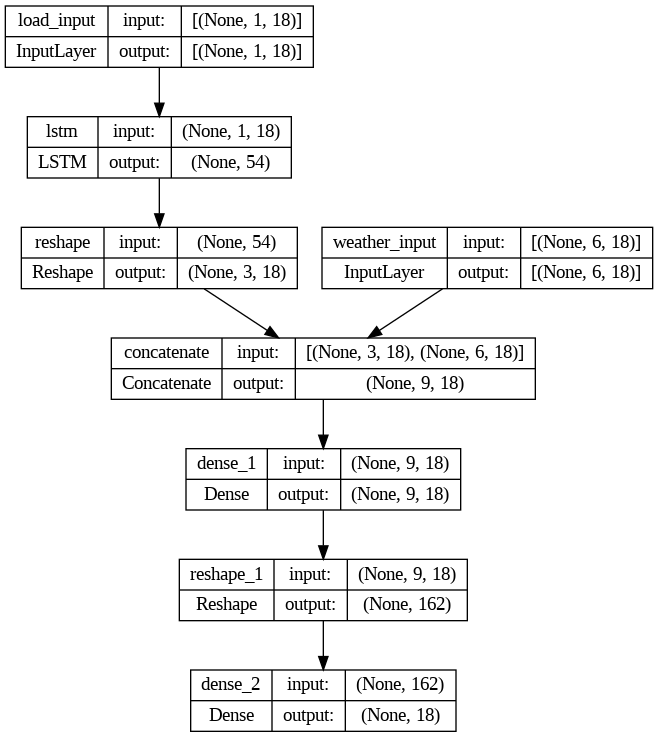

In [12]:
def create_multi_input_model(recurrent_dropout=0.05,lstm_multiple = 3,
                      learning_rate=0.00005,var_num = 6,
                      hist_window=18,forecast_window=18):
  
  load_input = ly.Input(shape=(1,hist_window), name='load_input')
  weather =  ly.Input(shape=(var_num,hist_window), name='weather_input')
  lstm = ly.LSTM(lstm_multiple * hist_window,  recurrent_dropout=recurrent_dropout, name = 'lstm')(load_input)
  lstm = ly.Reshape((lstm_multiple, hist_window))(lstm)
  all_input = ly.Concatenate(axis=1)([lstm, weather])
  forcast = ly.Dense(forecast_window)(all_input)
  forcast = ly.Reshape(((var_num+lstm_multiple)*hist_window,))(forcast) # can use a convolution layer here? 
  forcast = ly.Dense(forecast_window)(forcast)

  model = Model(inputs = [load_input, weather], outputs = [forcast])

  return model
model = create_multi_input_model() 
plot_model (model, show_shapes=True)

In [13]:
# def model_train(model, load_input, weather_input, load_target):
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Test"
model_name = 'test_LSTM_mulyi_input_hum.h5'

# model = create_multi_input_model()
model.compile(loss='mean_squared_error', optimizer='adam')

if train_b:
  model_hist = model.fit([train[:,0:1,:], train[:,1:,:]], label_t, epochs=5)
  model.save(f"{MODEL_DIR}/{model_name}",save_format='h5')
else: 
  model.load_weights(f"{MODEL_DIR}/{model_name}") 

Epoch 1/5
16436/16436 [==============================] - 92s 5ms/step - loss: 0.0122
Epoch 2/5
16436/16436 [==============================] - 96s 6ms/step - loss: 0.0062
Epoch 3/5
16436/16436 [==============================] - 106s 6ms/step - loss: 0.0060
Epoch 4/5
16436/16436 [==============================] - 98s 6ms/step - loss: 0.0059
Epoch 5/5
16436/16436 [==============================] - 95s 6ms/step - loss: 0.0058


In [14]:
label_t

array([[-0.61598361, -0.64129281, -0.64155195, ..., -0.8246765 ,
        -0.82450374, -0.83668325],
       [-0.64129281, -0.64155195, -0.67852237, ..., -0.82450374,
        -0.83668325, -0.82692236],
       [-0.64155195, -0.67852237, -0.64993076, ..., -0.83668325,
        -0.82692236, -0.87538126],
       ...,
       [-0.92802266, -0.91649575, -0.92989131, ..., -1.13243397,
        -1.14171606, -1.13945861],
       [-0.91649575, -0.92989131, -0.89900217, ..., -1.14171606,
        -1.13945861, -1.14245374],
       [-0.92989131, -0.89900217, -0.98199776, ..., -1.13945861,
        -1.14245374, -1.19284348]])

In [15]:
pred = model.predict([train[:,0:1,:], train[:,1:,:]])
pred

16436/16436 [==============================] - 46s 3ms/step


array([[-0.63356054, -0.64399505, -0.6551038 , ..., -0.7618421 ,
        -0.7679063 , -0.7748754 ],
       [-0.63971233, -0.6498616 , -0.6600953 , ..., -0.7560207 ,
        -0.76202047, -0.76759875],
       [-0.6559502 , -0.66640615, -0.67723465, ..., -0.7905631 ,
        -0.7985647 , -0.80601   ],
       ...,
       [-0.952666  , -0.97058064, -0.98792005, ..., -1.1761585 ,
        -1.190762  , -1.2041447 ],
       [-0.9656765 , -0.98342234, -0.9990659 , ..., -1.1918969 ,
        -1.2085027 , -1.2222354 ],
       [-0.9658701 , -0.9828046 , -0.9963056 , ..., -1.1401224 ,
        -1.149811  , -1.1586986 ]], dtype=float32)

3284/3284 [==============================] - 9s 3ms/step
Total Test Score: 379.69 RMSE
90 Min Test Score: 143.52 RMSE
Relative Test Score: 2.47 perc RMSE


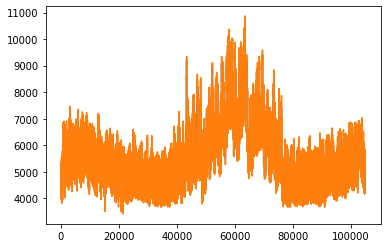

In [16]:
# make predictions
valid,label_v = x[n-t:], y[n-t:]
label_p   = model.predict([valid[:,0:1,:], valid[:,1:,:]])

## invert predictions
label_p = untransform_dataset(label_p)
label_v = untransform_dataset(label_v)

# calculate root mean squared error
print('Total Test Score: %.2f RMSE' % (RMSE_list(label_v, label_p)))

for i,ln in enumerate(label_p):
  if i==0: 
    label_p_plot=list(label_p[0])
    label_v_plot=list(label_v[0])
  else:
    label_p_plot=label_p_plot+ [label_p[i][-1]]
    label_v_plot=label_v_plot+ [label_v[i][-1]]

print('90 Min Test Score: %.2f RMSE' % (RMSE(label_v_plot, label_p_plot)))
print('Relative Test Score: %.2f perc RMSE' % (100*RRMSE(label_v_plot, label_p_plot)))

plt.plot(label_v_plot);
plt.plot(label_p_plot)
plt.show()